<>:210: SyntaxWarning: invalid escape sequence '\D'
<>:210: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-179148746.py:210: SyntaxWarning: invalid escape sequence '\D'
  print(f"\Diagnostics: {res['df'].columns.name or ''} model = {which} ======")
/tmp/ipython-input-179148746.py:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vm = float(x @ Vb @ x.T)
/tmp/ipython-input-179148746.py:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vm = float(x @ Vb @ x.T)


Starting Inflation Modeling and Robustness Checks...

[STEP 1/4] Running CPI pipeline...

=== CPI NOWCAST for October 2025 ===
Seasonal (AR+month dummies): +0.18% 95% PI [-0.41%, 0.78%]
AR+Sentiment (AR(1)+S_z): +0.21% 95% PI [-0.59%, 1.01%]

[STEP 2/4] Running CPI Diagnostics...
\Diagnostics:  model = Seasonal ======
Residual mean: +0.0000, std: 0.2853, N=268

Ljung–Box (H0: no autocorr):
      lb_stat     lb_pvalue
6   47.268513  1.654005e-08
12  65.398270  2.300946e-09

ARCH LM (H0: no ARCH): stat=93.41, p=0.000
White test (H0: homoskedastic): stat=89.64, p=0.000
Normality (AD): stat=2.78, p=0.000
CUSUM not available: unsupported operand type(s) for ** or pow(): 'RegressionResultsWrapper' and 'int'

VIF (rule of thumb < 10):
const       13.56
MoM_Lag1     1.82
month_2      2.43
month_3      1.86
month_4      1.84
month_5      1.88
month_6      1.87
month_7      1.91
month_8      2.02
month_9      1.87
month_10     1.84
month_11     1.84
month_12     1.87
Name: VIF, dtype: float64
\D

/tmp/ipython-input-179148746.py:226: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_stat, arch_p, _, _ = het_arch(np.asarray(m.resid), maxlag=12)
/tmp/ipython-input-179148746.py:226: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_stat, arch_p, _, _ = het_arch(np.asarray(m.resid), maxlag=12)
/tmp/ipython-input-179148746.py:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vm = float(x @ Vb @ x.T)
/tmp/ipython-input-179148746.py:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vm = float(x @ Vb @ x.T)



=== CPIH NOWCAST for October 2025 ===
Seasonal (AR+month dummies): +3.80% 95% PI [-28.98%, 36.59%]
AR+Sentiment (AR(1)+S_z): +1.99% 95% PI [-29.86%, 33.85%]

[STEP 4/4] Running CPIH Diagnostics...
\Diagnostics:  model = Seasonal ======
Residual mean: -0.0000, std: 16.0934, N=268

Ljung–Box (H0: no autocorr):
      lb_stat  lb_pvalue
6   17.349483   0.008081
12  35.996626   0.000324

ARCH LM (H0: no ARCH): stat=63.00, p=0.000
White test (H0: homoskedastic): stat=35.95, p=0.056
Normality (AD): stat=4.81, p=0.000
CUSUM not available: unsupported operand type(s) for ** or pow(): 'RegressionResultsWrapper' and 'int'

VIF (rule of thumb < 10):
const       12.23
MoM_Lag1     1.02
month_2      1.84
month_3      1.84
month_4      1.84
month_5      1.84
month_6      1.87
month_7      1.87
month_8      1.87
month_9      1.88
month_10     1.85
month_11     1.84
month_12     1.84
Name: VIF, dtype: float64
\Diagnostics:  model = AR+Sent ======
Residual mean: -0.0000, std: 16.1350, N=268

Ljung–Box 

/tmp/ipython-input-179148746.py:226: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_stat, arch_p, _, _ = het_arch(np.asarray(m.resid), maxlag=12)
/tmp/ipython-input-179148746.py:226: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_stat, arch_p, _, _ = het_arch(np.asarray(m.resid), maxlag=12)


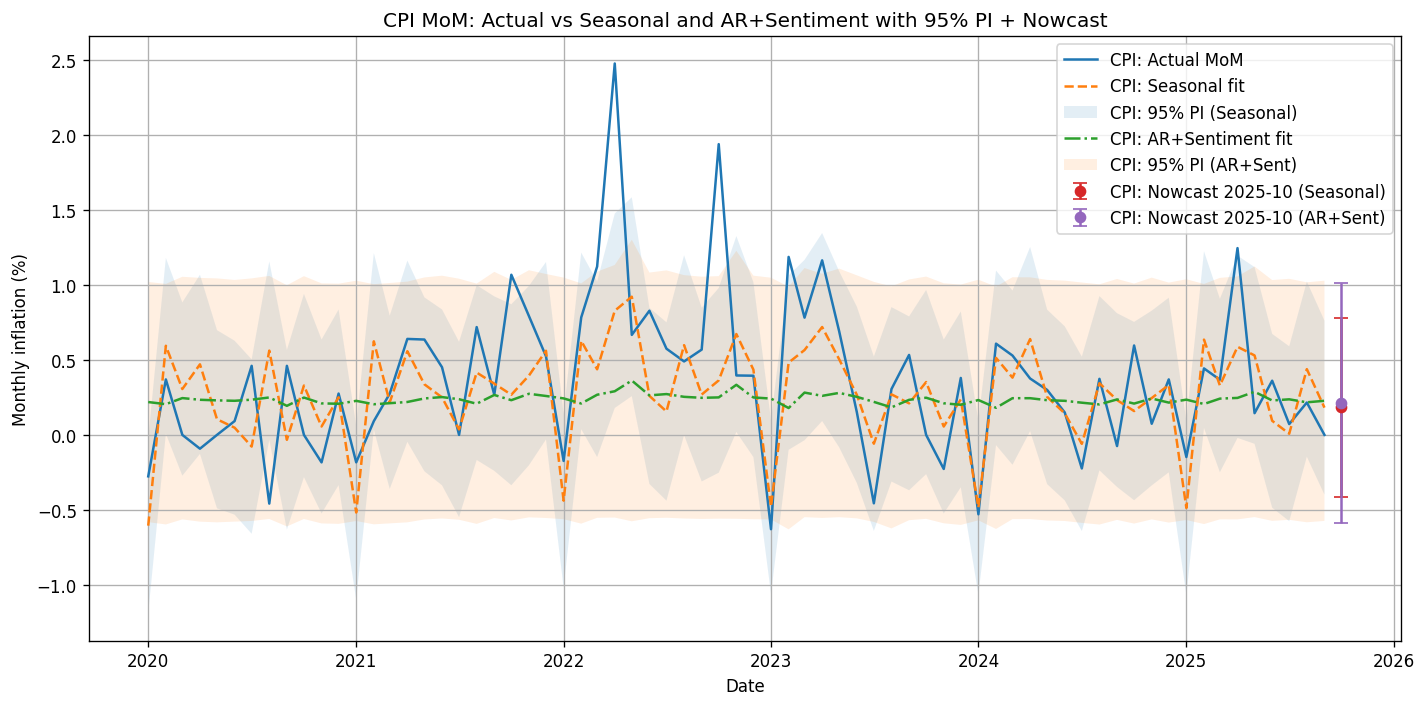

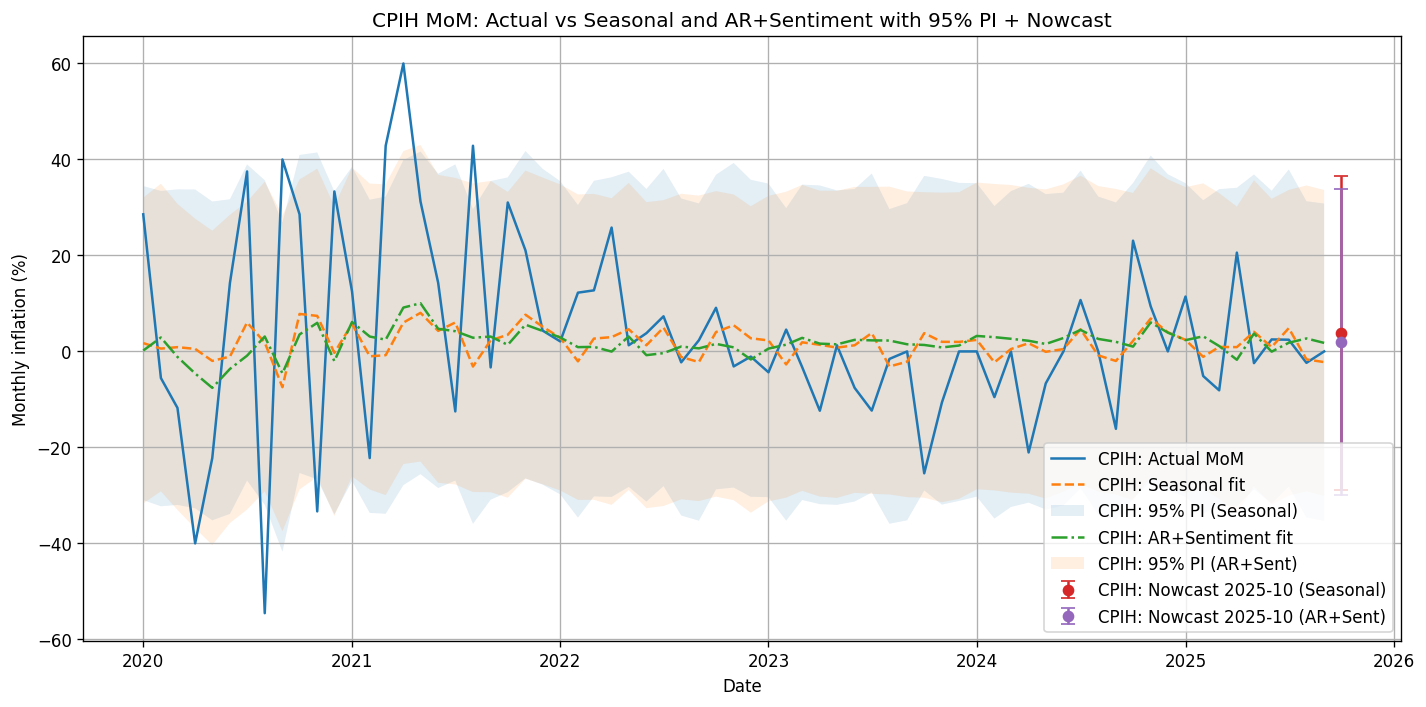


Robustness checks complete. Check the output above for Ljung-Box, ARCH, White, CUSUM, and VIF results.


In [7]:
# TITLE: Inflation Nowcasting with High-Frequency Sentiment Data (Neptune North Challenge)
# DATE:02/11/2025
# DESCRIPTION: This script loads official CPI/CPIH data and Guardian sentiment data to build two OLS regression models (Seasonal and AR+Sentiment) for monthly inflation (MoM) nowcasting. It includes a series of robust diagnostic checks (Ljung-Box, ARCH, CUSUM, VIF) on the residuals.


import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Robustness and Diagnostic Check Imports
from statsmodels.stats.diagnostic import acorr_ljungbox, het_white, het_arch, breaks_cusumolsresid, normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor

#   SETTINGS change later if error
plt.rcParams["figure.dpi"] = 120

ONS_CPI_PATH = "series-221025.csv"
ONS_CPIH_PATH = "series-021125.csv"
GUARDIAN_PATH = "guardian_sentiment_monthly_2000_to_now.csv"
CPI_CDID = "D7BT"  # ONS CDID for CPI all-items index
CPIH_CDID = None
START_PLOT = pd.Timestamp("2020-01-01")  # Start date for plot visualization
TRAIN_END = pd.Timestamp("2019-12-01")  # End date for training/standardization
HARD_FLOOR = pd.Timestamp("2003-01-01") # Earliest acceptable data start


def _looks_like_year_mon_col(df):
    # Checks for 'YYYY MON' column format in ONS files?
    if df.shape[1] < 2: return False
    try:
        pat = re.compile(r"^\s*\d{4}\s+(JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\s*$", re.I)
        return df.iloc[:,0].astype(str).str.match(pat).sum() > 3
    except Exception:
        return False

def load_ons_monthly(path, prefer_cdid=None):
    # Loads and processes ONS data into Monthly Inflation
    try:
        df = pd.read_csv(path)
        df.columns = [c.strip() for c in df.columns]
        # Logic for 'tidy' ONS format
        if {"CDID","Time","Value"}.issubset(df.columns):
            if prefer_cdid is not None:
                df = df[df["CDID"].astype(str).str.upper() == prefer_cdid.upper()].copy()
                if df.empty:
                    raise ValueError(f"CDID '{prefer_cdid}' not found in {path}.")
            else:
                first_series = df["CDID"].iloc[0]
                df = df[df["CDID"] == first_series].copy()
            df = df.rename(columns={"Time":"Date","Value":"Index"})
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df["Index"] = pd.to_numeric(df["Index"], errors="coerce")
            df = df.dropna(subset=["Date","Index"]).sort_values("Date").set_index("Date").asfreq("MS")
            out = pd.DataFrame(index=df.index)
            out["CPI_Level"] = df["Index"]
            out["Inflation_MoM"] = out["CPI_Level"].pct_change() * 100
            return out

        # Logic for 2-column
        elif _looks_like_year_mon_col(df):
            raw = df.iloc[:, :2].copy()
            raw.columns = ["Date_Str","CPI_Level"]
            pat = re.compile(r"^\s*\d{4}\s+(JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\s*$", re.I)
            raw = raw[raw["Date_Str"].astype(str).str.match(pat)]
            raw["Date"] = pd.to_datetime(raw["Date_Str"], format="%Y %b", errors="coerce")
            raw["CPI_Level"] = pd.to_numeric(raw["CPI_Level"], errors="coerce")
            raw = raw.dropna(subset=["Date","CPI_Level"]).set_index("Date").sort_index().asfreq("MS")
            raw["Inflation_MoM"] = raw["CPI_Level"].pct_change() * 100
            return raw[["CPI_Level","Inflation_MoM"]]
        else:
            raise ValueError("File not recognised as tidy time series or 2-column monthly layout.")
    except Exception as e:
        raise RuntimeError(f"ONS loader failed for {path}: {e}")

def load_guardian(path):
    # Loads and resamples Guardian sentiment to monthly frequency
    g = pd.read_csv(path, parse_dates=["month_year"], index_col="month_year")
    if "avg_sentiment" not in g.columns:
        raise RuntimeError("Guardian file must have 'avg_sentiment'.")
    g = g.resample("MS").mean(numeric_only=True).rename(columns={"avg_sentiment":"Guardian_Sentiment"})
    return g[["Guardian_Sentiment"]]

def fit_ols_hac(y, X):
    # Fits OLS regression model
    Xc = sm.add_constant(X, has_constant="add")
    dfm = pd.concat([y, Xc], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    if dfm.empty: return None
    y_ = dfm.iloc[:,0]
    X_ = dfm.iloc[:,1:]
    return sm.OLS(y_, X_).fit(cov_type="HAC", cov_kwds={"maxlags":12})

def predictive_band(model, X_like):
    Xc = sm.add_constant(X_like, has_constant="add")
    Xc = Xc.reindex(columns=model.params.index, fill_value=0.0)
    Xc = Xc.replace([np.inf, -np.inf], np.nan).dropna()
    if Xc.empty:
        return pd.Series(dtype=float), pd.Series(dtype=float), pd.Series(dtype=float)
    yhat = model.predict(Xc)
    Vb = model.cov_params().values
    sig2 = float(model.scale)
    Xmat = Xc.values.astype(float)
    vm = np.einsum("ij,jk,ik->i", Xmat, Vb, Xmat)
    se = np.sqrt(np.maximum(vm + sig2, 0.0))
    return yhat, yhat - 1.96*se, yhat + 1.96*se

def predict_point_PI(model, row):
    Xrow = sm.add_constant(row, has_constant="add").reindex(columns=model.params.index, fill_value=0.0)
    yhat = float(model.predict(Xrow).iloc[0])
    Vb = model.cov_params().values
    sig2 = float(model.scale)
    x = Xrow.values.astype(float)
    vm = float(x @ Vb @ x.T)
    se = float(np.sqrt(max(vm + sig2, 0.0)))
    return yhat, yhat - 1.96*se, yhat + 1.96*se

def run_pipeline(label, ons_path, prefer_cdid, guardian_path):

    #  series + sentiment
    base = load_ons_monthly(ons_path, prefer_cdid)
    g = load_guardian(guardian_path)
    df = base.join(g, how="left")
    df.columns.name = label

    first_sent = df["Guardian_Sentiment"].dropna().index.min()
    floor = HARD_FLOOR if pd.isna(first_sent) else max(HARD_FLOOR, first_sent)
    df = df[df.index >= floor].copy()

    # Seasonality, AR(1), Standardised Sentiment
    mdum = pd.get_dummies(df.index.month, prefix="month", drop_first=True).set_index(df.index).astype(int)
    df = pd.concat([df, mdum], axis=1)
    df["Target_MoM"] = df["Inflation_MoM"]
    df["MoM_Lag1"] = df["Inflation_MoM"].shift(1)

    # Z-score standardisation
    mu_s = df.loc[df.index <= TRAIN_END, "Guardian_Sentiment"].mean()
    sd_s = df.loc[df.index <= TRAIN_END, "Guardian_Sentiment"].std()
    df["S_z"] = ((df["Guardian_Sentiment"] - mu_s) / sd_s).fillna(0.0)

    # 4) Model definitions (Feature sets)
    dummy_cols = [c for c in df.columns if c.startswith("month_")]
    def feats_seasonal(F): return F[["MoM_Lag1"] + dummy_cols]
    def feats_ar_sent(F): return F[["MoM_Lag1", "S_z"]]

    # 5) Model fitting (Full history)
    m_seasonal = fit_ols_hac(df["Target_MoM"], feats_seasonal(df))
    m_arx = fit_ols_hac(df["Target_MoM"], feats_ar_sent(df))

    # 6) Next month input for nowcasting
    last_obs = df.index[-1]
    next_month = last_obs + pd.offsets.MonthBegin(1)

    row_seas = feats_seasonal(df).iloc[[-1]].copy()
    row_seas.index = [next_month]
    for m in dummy_cols:
        mnum = int(m.split("_")[-1])
        row_seas[m] = 1 if mnum == next_month.month else 0
    row_seas["MoM_Lag1"] = df.iloc[-1]["Inflation_MoM"]

    row_arx = feats_ar_sent(df).iloc[[-1]].copy()
    row_arx.index = [next_month]
    row_arx["MoM_Lag1"] = df.iloc[-1]["Inflation_MoM"]

    yh_seas, lo_seas, hi_seas = predict_point_PI(m_seasonal, row_seas)
    yh_arx, lo_arx, hi_arx = predict_point_PI(m_arx, row_arx)

    # 7) Plotting results nowcast
    fig, ax = plt.subplots(figsize=(12,6))
    y_act = df.loc[df.index >= START_PLOT, "Target_MoM"]
    ax.plot(y_act.index, y_act.values, label=f"{label}: Actual MoM")

    yhat_s, l_s, h_s = predictive_band(m_seasonal, feats_seasonal(df.loc[df.index >= START_PLOT]))
    yhat_a, l_a, h_a = predictive_band(m_arx, feats_ar_sent(df.loc[df.index >= START_PLOT]))

    if not yhat_s.empty:
        ax.plot(yhat_s.index, yhat_s.values, linestyle="--", label=f"{label}: Seasonal fit")
        ax.fill_between(yhat_s.index, l_s.values, h_s.values, alpha=0.12, label=f"{label}: 95% PI (Seasonal)")
    if not yhat_a.empty:
        ax.plot(yhat_a.index, yhat_a.values, linestyle="-.", label=f"{label}: AR+Sentiment fit")
        ax.fill_between(yhat_a.index, l_a.values, h_a.values, alpha=0.12, label=f"{label}: 95% PI (AR+Sent)")

    ax.errorbar([next_month], [yh_seas],
                yerr=[[yh_seas - lo_seas], [hi_seas - yh_seas]],
                fmt="o", capsize=4, label=f"{label}: Nowcast {next_month:%Y-%m} (Seasonal)")
    ax.errorbar([next_month], [yh_arx],
                yerr=[[yh_arx - lo_arx], [hi_arx - yh_arx]],
                fmt="o", capsize=4, label=f"{label}: Nowcast {next_month:%Y-%m} (AR+Sent)")

    ax.set_title(f"{label} MoM: Actual vs Seasonal and AR+Sentiment with 95% PI + Nowcast")
    ax.set_xlabel("Date"); ax.set_ylabel("Monthly inflation (%)")
    ax.grid(True); ax.legend(); plt.tight_layout()

    print(f"\n=== {label} NOWCAST for {next_month:%B %Y} ===")
    print(f"Seasonal (AR+month dummies): {yh_seas:+.2f}% 95% PI [{lo_seas:.2f}%, {hi_seas:.2f}%]")
    print(f"AR+Sentiment (AR(1)+S_z): {yh_arx:+.2f}% 95% PI [{lo_arx:.2f}%, {hi_arx:.2f}%]")

    return {
        "df": df,
        "models": {"Seasonal": m_seasonal, "AR+Sent": m_arx},
        "nowcast_month": next_month,
        "nowcasts": {
            "Seasonal": (yh_seas, lo_seas, hi_seas),
            "AR+Sent": (yh_arx, lo_arx, hi_arx),
        },
    }

#ROBUSTNESS ?
def diag_report(res, which="Seasonal"):
    # Runs and prints standard model diagnostics for robustness
    print(f"\Diagnostics: {res['df'].columns.name or ''} model = {which} ======")
    m = res["models"]["Seasonal"] if which=="Seasonal" else res["models"]["AR+Sent"]

    if m is None:
        print("Model failed to fit. Cannot run diagnostics.")
        return

    resid = m.resid.dropna()
    print(f"Residual mean: {resid.mean():+.4f}, std: {resid.std():.4f}, N={len(resid)}")

    # Serial correlation
    lb = acorr_ljungbox(resid, lags=[6,12], return_df=True)
    print("\nLjung–Box (H0: no autocorr):")
    print(lb)

    # conditional heteroskedasticity?
    arch_stat, arch_p, _, _ = het_arch(np.asarray(m.resid), maxlag=12)
    print(f"\nARCH LM (H0: no ARCH): stat={arch_stat:.2f}, p={arch_p:.3f}")

    # Heteroskedasticity (White test)
    X = m.model.exog
    w_stat, w_p, _, _ = het_white(m.resid, X)
    print(f"White test (H0: homoskedastic): stat={w_stat:.2f}, p={w_p:.3f}")

    # Normality - Anderson–Darling
    ad_stat, ad_p = normal_ad(resid)
    print(f"Normality (AD): stat={ad_stat:.2f}, p={ad_p:.3f}")

    # Stability
    try:
        cusum_stat, cusum_p, _ = breaks_cusumolsresid(m, ddof= m.df_model)
        print(f"CUSUM (H0: stable params): stat={cusum_stat:.2f}, p={cusum_p:.3f}")
    except Exception as e:
        print(f"CUSUM not available: {e}")

    # Multicollinearity
    try:
        exog = pd.DataFrame(m.model.exog, columns=m.model.exog_names)
        vif = pd.Series(
            [variance_inflation_factor(exog.values, i) for i in range(exog.shape[1])],
            index=exog.columns, name="VIF"
        )
        print("\nVIF (rule of thumb < 10):")
        print(vif.round(2))
    except Exception as e:
        print(f"VIF not computed: {e}")

    if which=="AR+Sent" and "S_z" in m.params.index:
        X_restr = pd.DataFrame(m.model.exog, columns=m.model.exog_names).drop(columns=["S_z"], errors="ignore")
        y = m.model.endog
        m_restr = sm.OLS(y, X_restr).fit(cov_type="HAC", cov_kwds={"maxlags":12})
        r2_full, r2_restr = m.rsquared, m_restr.rsquared
        if (1 - r2_restr) > 1e-6:
            part_r2 = (r2_full - r2_restr) / (1 - r2_restr)
            print(f"\nIncremental R^2 from sentiment (partial R^2): {part_r2:.4f}")
        else:
            print("\nIncremental R^2 from sentiment: Not computable (R-squared of restricted model is too high).")
        print(f"Coef(S_z) = {m.params['S_z']:+.3f}, t = {m.tvalues['S_z']:.2f}, p = {m.pvalues['S_z']:.3f}")



print("Starting Inflation Modeling and Robustness Checks...")

# Run
print("\n[STEP 1/4] Running CPI pipeline...")
res_cpi = run_pipeline("CPI", ONS_CPI_PATH, CPI_CDID, GUARDIAN_PATH)

print("\n[STEP 2/4] Running CPI Diagnostics...")
diag_report(res_cpi, "Seasonal")
diag_report(res_cpi, "AR+Sent")


print("\n[STEP 3/4] Running CPIH pipeline...")
res_cpih = run_pipeline("CPIH", ONS_CPIH_PATH, CPIH_CDID, GUARDIAN_PATH)

print("\n[STEP 4/4] Running CPIH Diagnostics...")
diag_report(res_cpih, "Seasonal")
diag_report(res_cpih, "AR+Sent")


plt.show()

print("\nRobustness checks complete. Check the output above for Ljung-Box, ARCH, White, CUSUM, and VIF results.")